#### SUM main + ExMAS + MSA + KPI


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import random

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<AxesSubplot:>

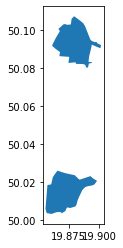

In [5]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas.plot()

In [6]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [7]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [8]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [9]:
# Chosen hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

In [10]:
def calc_KPIs(df):
    '''
    calculates such KPI indicaors: 
    del_VehHourTrav - vehicle hours reduction,
    del_PassUtility - travellers utility gains,
    occupancy,
    del_PassHourTrav - passenger hours increase,
    del_fleet_size - potential fleet size reduction
    input: dataframe with KPIs for each area
    output: dataframe with calculated KPI indicators to analyse '''
    for i, row in df.iterrows():
        df.loc[i, 'del_VehHourTrav'] = abs(row['VehHourTrav'] - row['VehHourTrav_ns']) / row['VehHourTrav_ns']
        df.loc[i, 'del_PassUtility'] = abs((row['PassUtility'] - row['PassUtility_ns']) / row['PassUtility_ns'])
        df.loc[i, 'Occupancy'] = row['PassHourTrav'] / row['VehHourTrav']
        df.loc[i, 'del_PassHourTrav'] = abs((row['PassHourTrav'] - row['PassHourTrav_ns']) / row['PassHourTrav_ns'])
        df.loc[i, 'del_fleet_size'] = abs((row['fleet_size_shared'] - row['fleet_size_nonshared']) / row['fleet_size_nonshared'])
    return df

In [ ]:
def simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                 degree=1, N=1, max_iter=100, ASC=1.95, results_period=0) -> tuple:
    '''calculate utilities for each traveller of the given area for single and shared rides (ExMAS)
    calculate ASC if calc_ASC = True
    apply method of successive averages (MSA) for travel times variable

    input:  gdf_areas - SUM areas [geopandas dataframe]
    df_demo - city population distribution [csv]
    gdf_centroid - centroids of city zones [geojson]
    od - ODMs [excel], od_probs - dataframe with destination probabilities
    hubs - choseen hub locations [dict]
    inData, params, OTP_API, degree - ExMAS input
    N - number of replications (generate sample for the area)
    iterations - number of iterations for ExMAS
    calc_ASC - flag to calculate ASC
    ASC - alternative specific constant
    output: [0] - mean results for N replications for each area sample
        ex. {'Skotniki': tw_PT_OD, tw_PT_HD, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM}
    [1] - results of the last iteration for sample of each area:
        ex. {'Skotniki': origin_x, origin_y, destination_x, destination_y, treq, u_PT_OD,
                              origin, hub, dist, ttrav, tarr, u_SUM_OD, p_SUM}
    [2] - dictionary with KPIs
    [3] - dictionary with average expected times [t_expected]
    [4] - dictionary with times, ex. {'Skotniki': t_0, ttrav_sh_i, t_expected_i}
    [5] - lists with asc coefficients
    '''

    areas_res = {} # resulting dataFrame with averages
    sum_res = {} # resulting dataFrame from the last iteration
    avg_times = {} # dataframe to store average times for each area
    times = {} # dictionary to store dataframes with times
    kpis_dict = {}
    asc_dict = {} # to store [asc's] for each area
    
    def iterate(df_sum):
        '''function to calculate utilities and probs for shared option 
        1) when applying MSA before the system stabilizes
        2) for obtaining KPIs after the convergence
        '''
        sum_demand = df_sum[df_sum.apply(lambda row: random.random() < row['p_SUM'], axis=1)] # SUM travelers
        print('sum_demand sample', sum_demand.shape[0])
        df_sum_sh = sum_demand[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'treq', 'origin', 'destination', 'dist', 't_expected', 'u_PT_OD', 'nTrips']]
        df_sum_sh['nTrips'] = df_sum_sh['nTrips'] + 1
        
        fncs.run_ExMAS(df_sum_sh, inData, params, hub, degree)
        
        # sort data after ExMAS shuffled trips to assign ttrav_sh to SUM travelers
        inData_reqs_sorted = inData.sblts.requests.sort_values('index') 
        inData_reqs_sorted.set_index('index', inplace=True)
        inData_reqs_sorted = inData_reqs_sorted.rename_axis(None)
        df_sum_sh['ttrav_sh'] = inData_reqs_sorted['ttrav_sh']
        df_sum_sh['tarr'] = df_sum_sh.treq + df_sum_sh.apply(
            lambda req: pd.Timedelta(req.ttrav_sh, 's').floor('s'), axis=1)
        # MSA
        df_sum_sh['t_expected'] = (df_sum_sh['nTrips'] - 1) / df_sum_sh['nTrips'] * df_sum_sh.t_expected + \
            df_sum_sh.ttrav_sh / df_sum_sh['nTrips']
    
        # assign indexes of shared trips to column 'indexes_sum' and RESET INDEX to calculate OTP
        df_sum_sh.insert(0, 'indexes_sum', df_sum_sh.index)
        df_sum_sh = df_sum_sh.reset_index(drop=True)

        # Utility for PT HD
        u_pt_hd = df_sum_sh[['indexes_sum', 'origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
        # change origin x, y to hub coordinates
        u_pt_hd['origin_x'], u_pt_hd['origin_y'] = hub
        # treq for PT_HD = treq + ttrav_sh = tarr
        u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr)
        u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
        fncs.PT_utility(u_pt_hd, params)

        # drop rows with unsuccessful HD trips only for df_sum_sh (as u_PT_OD is the same as for the single trips)
        df_sum_sh = df_sum_sh.loc[u_pt_hd.index, :] 
        df_sum_sh.reset_index(drop=True, inplace=True)
        u_pt_hd.reset_index(drop=True, inplace=True)
        
        # Utility F OH - ADD t_w from ExMAS.sblts.rides
        df_sum_sh['u_F'] = df_sum_sh.apply(lambda request: request['t_expected'] * params.VoT * params.WtS + \
                                request['dist'] * params.price / 1000, axis=1)
                                
        # df_sum['u_PT_OD'] doesn't change for SUM demand
        df_sum_sh['u_PT_HD'] = u_pt_hd.u_PT
        df_sum_sh['u_SUM_OD'] = df_sum_sh.u_F + u_pt_hd.u_PT + ASC
        df_sum_sh['p_SUM'] = df_sum_sh.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
        return df_sum_sh
    
    for _, area in gdf_areas.iterrows():
        key = area["name"]
        dfres = pd.DataFrame()
        df_kpi_res = pd.DataFrame()
        ascs = [] # store ASC for each sample of each area
            
        for repl in range(N):
            converged = False
            df_times = pd.DataFrame()
            df_kpis = pd.DataFrame()
            avg_time = []
            area_reqs = fncs.define_demand(area, df_demo, gdf_centroid, od, od_probs, params)
            df = area_reqs[key].copy() # df with {O, D, Treq} for the area
            hub = hubs[key]
            print(repl + 1, "run simulations for area", key, ": sample size ", df.shape[0])

            # OPTION I: Utility for PT OD
            u_pt_od = df.copy()
            u_pt_od = fncs.run_OTP(u_pt_od, OTP_API) # define PT routes for each traveller
            fncs.PT_utility(u_pt_od, params)  
            
            df = df.loc[u_pt_od.index, :] # select requests with successful OD trips 
            df.reset_index(drop=True, inplace=True)

            # OPTION II: Utility for SUM (SINGLE TRIPS OH + PT HD)
            df_sum = df.copy()

            # Utility for SINGLE TRIPS OH
            df_sum['origin'] = df_sum.apply(lambda row: ox.nearest_nodes(inData.G, row['origin_x'], row['origin_y']), axis=1)
            df_sum['destination'] = ox.nearest_nodes(inData.G, hub[0], hub[1])
            df_sum['dist'] = df_sum.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
            df_sum['ttrav'] = df_sum['dist'].apply(lambda request: request / params.avg_speed)
            df_sum['tarr'] = df_sum.treq + df_sum.apply(lambda df_sum: pd.Timedelta(df_sum.ttrav, 's').floor('s'), axis=1)
            df_sum['t_expected'] = df_sum['ttrav'] # optimistic travel time

            # Utility for PT HD
            u_pt_hd = df_sum[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
            # change origin x, y to hub coordinates
            u_pt_hd['origin_x'], u_pt_hd['origin_y'] = hub
            # treq for PT_HD = treq + ttrav + transfertime
            u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr) + pd.Timedelta(params.transfertime, unit='s')
            u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
            fncs.PT_utility(u_pt_hd, params)

            u_pt_od = u_pt_od.loc[u_pt_hd.index, :] # drop rows with unsuccessful HD trips 
            u_pt_od.reset_index(drop=True, inplace=True)
            df_sum = df_sum.loc[u_pt_hd.index, :] 
            df_sum.reset_index(drop=True, inplace=True)
            u_pt_hd.reset_index(drop=True, inplace=True)
            
            df_sum['u_PT_OD'] = u_pt_od.u_PT # utility for PT OD
            df_sum['u_PT_HD'] = u_pt_hd.u_PT # utility for PT HD
            # Utility for SUM OD
            df_sum['u_SUM_OD'] = df_sum.apply(lambda request: request['ttrav'] * params.VoT * params.WtS + \
                                                request['dist'] * params.price / 1000, axis=1) + u_pt_hd.u_PT + ASC if ASC else \
                                 df_sum.apply(lambda request: request['ttrav'] * params.VoT * params.WtS + \
                                                request['dist'] * params.price / 1000, axis=1) + u_pt_hd.u_PT
            # probability of using SUM for each traveler in a single trip
            df_sum['p_SUM'] = df_sum.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                          (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
            print("p_SUM ",  df_sum.p_SUM.mean())
            
            # ASC calculation
            if not ASC:
                ASC = optimize.fsolve(lambda x: fncs.calc_E_p_sum(df_sum, x) - params.expected_prob, 0)[0]
                ascs.append(ASC)
                print(repl, "ASC ", key, ascs[repl])
              
            # times ---------------------------------------------------
            # optimistic ttrav, updated after each ExMAS iteration for travelers using SUM
            df_times['t_0'] = df_sum['ttrav']
            avg_time.append(df_sum.ttrav.mean()) # optimistic average travel time for ALL travelers before shared travel
                
            df_sum['nTrips'] = 0 # number of shared trips
                
            if degree > 1:
                i = 1
                while i < max_iter + 1 and not converged:
                # loop will run until the system will stabilize or until max_iter is reached
                    print('iteration ', i, ' for', key)
                    
                    df_sum_sh = iterate(df_sum)

                    # times ---------------------------------------------------
                    # dataframe with times: {t_0, t_ttrav_sh_i, t_expected_i}
                    df_times.loc[df_sum_sh.index, [f'ttrav_sh_{i}']] = df_sum_sh[['ttrav_sh']].values
                    df_times.loc[df_sum_sh.index, [f't_expected_{i}']] = df_sum_sh[['t_expected']].values

                    # Update p_SUM, t_expected and nTrips for travellers using SUM in the main table
                    df_sum.loc[df_sum_sh['indexes_sum'], ['p_SUM']] = df_sum_sh[['p_SUM']].values
                    df_sum.loc[df_sum_sh['indexes_sum'], ['t_expected']] = df_sum_sh[['t_expected']].values
                    df_sum.loc[df_sum_sh['indexes_sum'], ['nTrips']] = df_sum_sh[['nTrips']].values
                    avg_time.append(df_sum.t_expected.mean()) # average expected travel times for ALL travelers
                
                    # STOP ---------------------------------------------------
                    delta = abs(avg_time[i] - avg_time[i - 1]) / avg_time[i - 1]
                    # print("delta ", delta)
                    print("==============================================================")
                    # check if convergence criterion is met
                    if delta < params.convergence_threshold:
                        converged = True
                        print(f"convergence reached at iteration {i}")
                        print("===============================================================")

                    i += 1
                
                # after the system stabilization, obtain KPI's for the results_period
                if converged:
                    # run ExMAS to obtain KPIs
                    for i in range(results_period):
                        print('iteration after converged ', i + 1, ' for', key)
                        print("-----------------------------------------------------")
                        
                        df_sum_sh = iterate(df_sum)
                        df_kpis[i] = inData.sblts.res # obtain kpis after the system stabilized

                        # times ---------------------------------------------------
                        df_times.loc[df_sum_sh.index, [f'ttrav_sh_{i}']] = df_sum_sh[['ttrav_sh']].values
                        df_times.loc[df_sum_sh.index, [f't_expected_{i}']] = df_sum_sh[['t_expected']].values

                        # Update p_SUM, t_expected and nTrips for travellers using SUM in the main table
                        df_sum.loc[df_sum_sh['indexes_sum'], ['p_SUM']] = df_sum_sh[['p_SUM']].values
                        df_sum.loc[df_sum_sh['indexes_sum'], ['t_expected']] = df_sum_sh[['t_expected']].values
                        df_sum.loc[df_sum_sh['indexes_sum'], ['nTrips']] = df_sum_sh[['nTrips']].values
                        avg_time.append(df_sum.t_expected.mean())
                else:
                    print(f"no convergence after {max_iter} iterations")
                    print("-----------------------------------------------------")

            df_means = pd.DataFrame([[u_pt_od.waitingTime.mean(), u_pt_hd.waitingTime.mean(), u_pt_od.u_PT.mean(),
                                        u_pt_hd.u_PT.mean(), df_sum.u_SUM_OD.mean(), df_sum.p_SUM.mean()]], 
                                        columns=['tw_PT_OD', 'tw_PT_HD', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM'])
            dfres = pd.concat([dfres, df_means], ignore_index=True)
            df_kpi_res = pd.concat([df_kpi_res, df_kpis], axis=1)
        
        # results
        sum_res[key] = df_sum
        areas_res[key] = dfres
        times[key] = df_times
        avg_times[key] = avg_time
        kpis_dict[key] = df_kpi_res
        asc_dict[key] = ascs

    return (areas_res, sum_res, kpis_dict, avg_times, times, asc_dict)

Run simulations to obtain KPIs

In [ ]:
rslts = simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                     degree=6, N=10, max_iter=30, ASC=1.95, results_period=20)

In [51]:
rslts[0]

{'Bronowice Wielkie':      tw_PT_OD   tw_PT_HD    u_PT_OD    u_PT_HD   u_SUM_OD     p_SUM
 0  135.123810  57.238095  13.677234  10.274642  15.832022  0.344656
 1  127.895735  59.350711  13.224572  10.365643  16.169330  0.138079
 2  147.555024  71.468900  13.880387  10.749627  16.634546  0.240559
 3  110.826923  41.841346  13.693518  10.396867  16.201742  0.224169
 4  115.382075  44.825472  13.612221  10.351015  16.108506  0.257760
 5  126.334906  51.603774  13.622210  10.346345  16.015062  0.347380
 6  112.360190  51.810427  13.314208  10.271640  15.934986  0.210067
 7  133.485849  68.259434  13.762441  10.503743  16.084932  0.216042
 8  117.542857  61.585714  14.083634  10.780192  16.405316  0.261424
 9  120.009662  57.386473  13.527156  10.230821  15.876627  0.245031,
 'Skotniki':      tw_PT_OD    tw_PT_HD    u_PT_OD    u_PT_HD   u_SUM_OD     p_SUM
 0  154.693333  123.066667  15.302975  11.449932  16.757679  0.298576
 1  145.351351  121.763514  14.124234  10.516861  15.849807  0.1917

In [40]:
print(rslts[0]['Bronowice Wielkie'].p_SUM.mean(), rslts[0]['Skotniki'].p_SUM.mean())

0.24851658744933833 0.2765252432894231


Average expected times obtained in 30 iterations:
- for area Bronowice Wielkie convergence was reached on iteration 9
- for area Skotniki convergence was reached on iteration 9

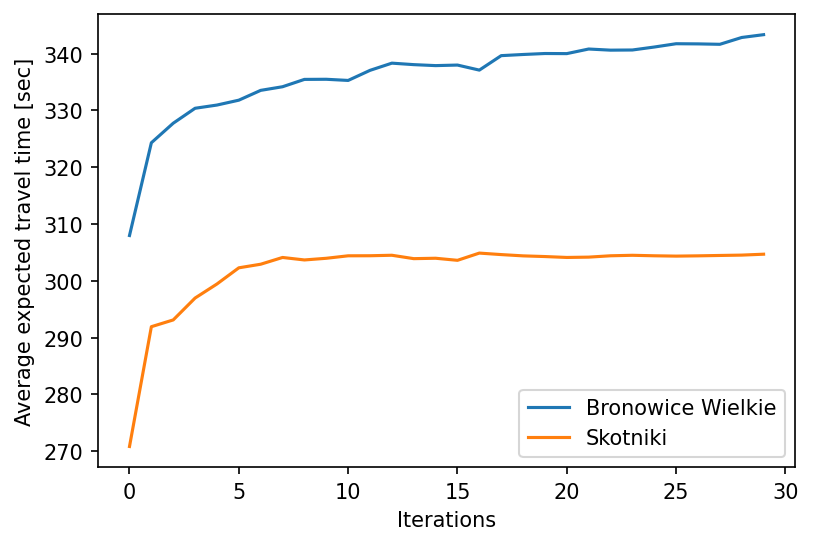

In [ ]:
# average t_expexted after applying MSA for 30 iterations
times_b = rslts[3]['Bronowice Wielkie']
times_s = rslts[3]['Skotniki']
plt.figure(dpi=150)
plt.plot(times_b, label='Bronowice Wielkie')
plt.plot(times_s, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.show()

KPIs for Bronowice Wielkie area as the result of such simulation parameters:
- N = 10 (number of replications of area demand) 
- max_iter = 30 (number of iterations of sum demand)
- results_period = 20 (iterations after the system stabilized) -> obtain KPIs

(23, 200)


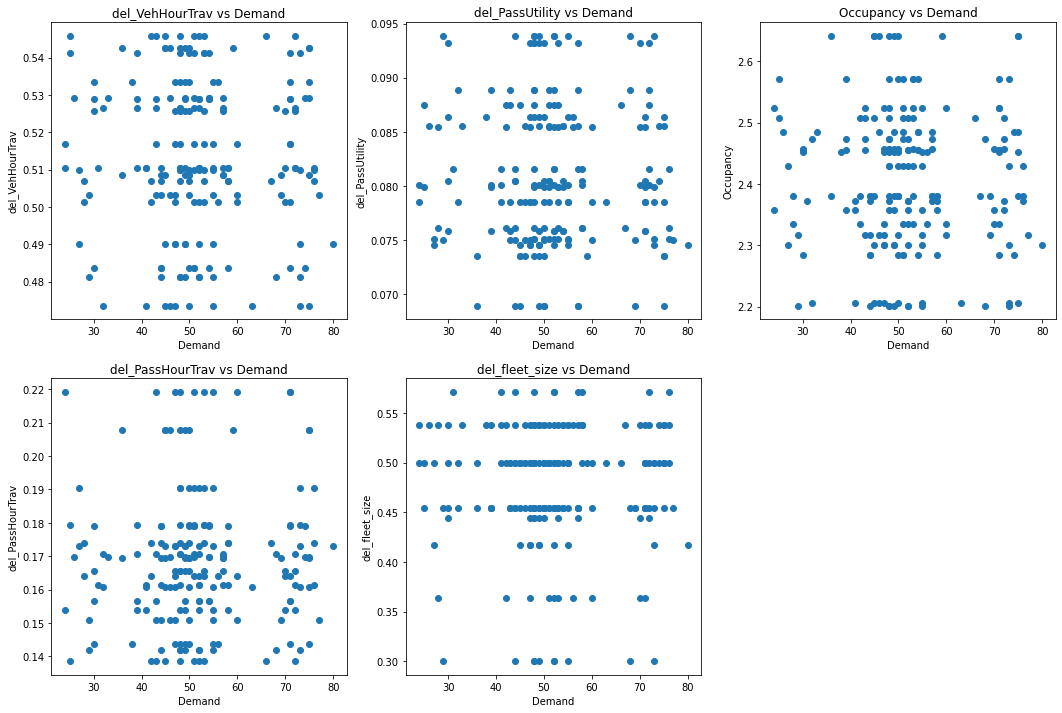

In [ ]:
# KPIs - rslts[3]
kpis_b = rslts[2]['Bronowice Wielkie']
print(kpis_b.shape)

kpis_b_t = kpis_b.T
kpis_b_calc = calc_KPIs(kpis_b_t)

cols_to_plot = ['del_VehHourTrav', 'del_PassUtility', 'Occupancy', 'del_PassHourTrav','del_fleet_size']
demand = kpis_b_calc['nR']
plt.figure(figsize=(18, 12))
for idx, col in enumerate(cols_to_plot, start=1):
    plt.subplot(2, 3, idx)
    plt.scatter(demand, kpis_b_calc[col], label=col)
    plt.title(f"{col} vs Demand")
    plt.xlabel("Demand")
    plt.ylabel(col)
    # plt.legend()
plt.show()

Run 100 simulations to calculate primary results:
- N = 100, max_iter = 1, degree = 6

In [ ]:
res_100 = simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                     degree=6, N=100, max_iter=1, ASC=1.95, results_period=0)

In [67]:
# results for averages for 100 simulation runs
res_100[0]['Bronowice Wielkie'].to_csv("output/res_100/b_avg_res_100.csv")
res_100[0]['Skotniki'].to_csv("output/res_100/s_avg_res_100.csv")

In [69]:
# results for sum table for the last simulation run
res_100[1]['Bronowice Wielkie'].to_csv("output/res_100/b_sum_100.csv")
res_100[1]['Skotniki'].to_csv("output/res_100/s_sum_100.csv")